In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/optiver_real_vol')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


#!pip install git+https://github.com/mawicks/mvarch


Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import pickle
from datetime import datetime
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_tree
from sklearn.utils import class_weight
from xgboost import plot_importance

from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.genmod.generalized_linear_model import GLM
import scipy.stats as stats

from sklearn.cluster import KMeans
import re

import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.utils import class_weight

from mlxtend.evaluate import bias_variance_decomp

#import mvarch
import numpy as np

import sys
from sklearn import covariance

from sklearn import cluster

from sklearn import manifold

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import torch

In [3]:
## load dataset

## cumulative log returns in first 10 mins.
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets')
log_return_book_wap1_df = pickle.load(open('log_return_book_wap1_df.pkl','rb'))
log_return_trade_df = pickle.load(open('log_return_trade_df.pkl','rb'))

log_return_book_wap1_df['time_id'] = log_return_book_wap1_df.index.values
log_return_trade_df['time_id'] = log_return_trade_df.index.values


## GROUND TRUTH Realized Volatitlies
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets')
first_10_min_wap1_vol_df = pickle.load(open('first_10_min_wap1_vol_df.pkl','rb'))

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets')
first_10_min_trade_price_vol_df = pickle.load(open('trade_price_real_vol_df.pkl','rb'))



reordered_time_ids = log_return_book_wap1_df['time_id'].values
log_return_book_wap1_df = log_return_book_wap1_df.drop(columns=['time_id'])
log_return_trade_df = log_return_trade_df.drop(columns=['time_id'])
unique_stock_ids = log_return_book_wap1_df.columns.values
unique_stock_ids = np.array([str(s) for s in unique_stock_ids])

In [ ]:
###### check that there are no +/-inf and nan values

if (
log_return_book_wap1_df.isna().sum().sum()+
log_return_trade_df.isna().sum().sum() != 0):
    print('there are nan values')

if (
log_return_book_wap1_df.isin([np.inf, -np.inf]).sum().sum()+
log_return_trade_df.isin([np.inf, -np.inf]).sum().sum()  != 0):
    print('there are inf values')



In [ ]:

def plot_embedding_n_visualize_graph(X, labels,title_name):

    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver="dense", n_neighbors=6
    )

    embedding = node_position_model.fit_transform(X.T).T



    plt.figure(1, facecolor="w", figsize=(35, 30))

    plt.clf()
    ax = plt.axes([0.0, 0.0, 1.0, 1.0])
    plt.axis("off")

    # Plot the graph of partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(
        embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
    )

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [
        [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
    ]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(
        segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
    )
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = "left"
            x = x + 0.002
        else:
            horizontalalignment = "right"
            x = x - 0.002
        if this_dy > 0:
            verticalalignment = "bottom"
            y = y + 0.002
        else:
            verticalalignment = "top"
            y = y - 0.002
        plt.text(
            x,
            y,
            name,
            size=10,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            bbox=dict(
                facecolor="w",
                edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                alpha=0.6,
            ),
        )

    plt.xlim(
        embedding[0].min() - 0.15 * np.ptp(embedding[0]),
        embedding[0].max() + 0.10 * np.ptp(embedding[0]),
    )
    plt.ylim(
        embedding[1].min() - 0.03 * np.ptp(embedding[1]),
        embedding[1].max() + 0.03 * np.ptp(embedding[1]),
    )
    plt.title(f'clusters of {title_name}',fontsize = 40)
    plt.show()

    return

In [ ]:
"""
GraphicalLassoCV
Visualize, inverse covariance/ precision / conditional correlation matrix
Cluster using affinity propagation
Dimensionality reduction and graph visualization
"""

def find_ret_corr_n_cluster(market_structure_data,name):

    """
    GraphicalLassoCV
    """

    alphas = np.logspace(-0.5, 1, num=10)
    edge_model = covariance.GraphicalLassoCV(alphas=alphas)

    # standardize the time series: using correlations rather than covariance
    # former is more efficient for structure recovery
    X = market_structure_data.to_numpy() # variation.copy().T
    X /= X.std(axis=0)
    edge_model.fit(X)


    """
    Visualize, inverse covariance/ precision / conditional correlation matrix
    """
    p = edge_model.precision_
    ax = plt.axes()
    sns.heatmap(data=p,ax=ax)
    ax.set_title(f'precision matrix of {name}')
    plt.show()


    """
    Cluster using affinity propagation
    """
    _, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
    n_labels = labels.max()

    cols = log_return_book_wap1_df.columns
    names = cols

    cluster_dict = {}
    print('\n')
    for i in range(n_labels + 1):
        #print(f"Cluster {i + 1}: {list(names[labels == i].values)}, Number of stocks: {len(names[labels == i].values)}")
        cluster_dict[i] = list(names[labels == i].values)


    """
    Dimensionality reduction and graph visualization
    """
    print('\n')
    #plot_embedding_n_visualize_graph(X, labels, name)

    return cluster_dict



In [ ]:

def mvarch_train_predict(mvarch_data,multivariate,device,returns_distrbution,mean):

    model = mvarch.model_factory(distribution= returns_distrbution, mean=mean, univariate="arch", constraint="scalar",multivariate=multivariate,device=device)

    fit_history = mvarch_data.values
    model.fit(fit_history)
    #print(f"Likelihood: {model.mean_log_likelihood(fit_history):.4f}")

    TAIL_SIZE = 1
    evaluate_history = mvarch_data.iloc[-TAIL_SIZE:].values

    (
        mv_scale_predicted,
        uv_scale_predicted,
        mean_predicted,
        mv_scale_history,
        uv_scale_history,
        mean_history,
    ) = model.predict(evaluate_history)

    next_time_id_uv_scale_predicted = (uv_scale_predicted * model.distribution.std_dev()).numpy()
    #next_time_id_uv_scale_predicted = (uv_scale_predicted * model.distribution.std_dev()).cpu().numpy()

    # print(
    #     f"Next time id volatility prediction:\n"
    #     f"{next_time_id_uv_scale_predicted}\n"
    # )

    next_time_id_mv_scale_predicted = (mv_scale_predicted @ mv_scale_predicted.T).numpy()
    #next_time_id_mv_scale_predicted = (mv_scale_predicted @ mv_scale_predicted.T).cpu().numpy()

    # print(
    #     f"Next time id correlation prediction:\n"
    #     f"{next_time_id_mv_scale_predicted}"
    # )


    # print(
    #     f"uv_scale_history:\n"
    #     f"{uv_scale_history }"
    # )

    # print(
    #     f"correlation. mv_scale_history:\n"
    #     f"{(mv_scale_history @ mv_scale_history.T).numpy()}"
    # )
    return next_time_id_uv_scale_predicted, next_time_id_mv_scale_predicted, model.distribution.std_dev()

In [ ]:
"""
Total time ids = 3830

split raw data into 3830//(9*22)) = 19.34 months / regimes.
63*9*2 = 1134 time ids each regime.

[   0  198  396  594  792  990 1188 1386 1584 1782 1980 2178 2376 2574 2772 2970 3168 3366 3564 3762 3831]
"""
split_idxs_into_regimes = np.array([])
Num_of_regimes = 22*9

for i in range(0,3831,Num_of_regimes): # split raw data into 3830//(9*22)) = 19.34 months
    split_idxs_into_regimes = np.append(split_idxs_into_regimes,i)
split_idxs_into_regimes = np.append(split_idxs_into_regimes,3831).astype(int)
print(split_idxs_into_regimes)

[   0  198  396  594  792  990 1188 1386 1584 1782 1980 2178 2376 2574
 2772 2970 3168 3366 3564 3762 3831]


In [ ]:
"""
MVARCH Training routine

"""

# Initialize DataFrame outside the loop
all_mvarch_uv_rvol_predicted_df = pd.DataFrame(columns=unique_stock_ids, index=reordered_time_ids)
all_mvarch_uv_model_std_predicted_df = pd.DataFrame(columns=unique_stock_ids, index=reordered_time_ids)
all_times_corr_matrix_dict = {}


tid_per_day = 9
days = 10  # 22 days_per_month, # 5 days_per_week , 10 days = 2 weeks
train_tid_length = tid_per_day * days  # time ids per month
split_idxs_into_regimes[-1] =  split_idxs_into_regimes[-1] - train_tid_length # to prevent overflow

def mvarch_regime_training(regime):

    for l in [regime]: #range(len(split_idxs_into_regimes) - 20): # -20
        start_idx = split_idxs_into_regimes[l]
        end_idx = split_idxs_into_regimes[l+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")

        name= 'log_return_book_wap1_df'
        market_structure_data = log_return_book_wap1_df.iloc[start_idx:end_idx + train_tid_length] # start_idx + train_tid_length to prevent lookahead bias

        # name= 'log_return_trade_df'
        # market_structure_data = log_return_trade_df.iloc[start_idx:end_idx - train_tid_length]

        cluster_dict = find_ret_corr_n_cluster(market_structure_data,name)

        if name == 'log_return_book_wap1_df':
            training_data = log_return_book_wap1_df
        elif name == 'log_return_trade_df':
            training_data = log_return_trade_df


        ###################### OPTIMIZED MVARCH routine ###############################

        # Define constants and parameters
        increment = 1
        start_tr_idx = start_idx
        end_tr_idx = end_idx # - train_tid_length # 3832 - train_tid_length
        sub_clust_len = 5 # number of stocks in sub-cluster.

        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Loop over time indices
        for start_time_idx in range(start_tr_idx, end_tr_idx, increment):
            end_time_idx = start_time_idx + train_tid_length
            print("\n\n")
            print(f"Start time index: {start_time_idx}, End time index: {end_time_idx}")
            print(f"time id start: {reordered_time_ids[start_time_idx]}, time id end: {reordered_time_ids[end_time_idx]}")

            # Get the book wap1 training data for this window
            train_df = training_data.iloc[start_time_idx:end_time_idx]

            time_id_corr_matrix_df = pd.DataFrame(columns=unique_stock_ids, index=unique_stock_ids)

            for c in cluster_dict.keys():
                clust_len = len(cluster_dict[c])  # remaining cluster length
                clust_stocks = cluster_dict[c]

                # Split clusters into subsets
                for i in range(0, clust_len, sub_clust_len):
                    clust_subset_stocks = clust_stocks[i:i + sub_clust_len]
                    subset_df = train_df[clust_subset_stocks]
                    print(f"Cluster {c + 1}: {clust_subset_stocks}, Number of stocks: {len(clust_subset_stocks)}")

                    next_time_id_uv_scale_predicted, next_time_id_mv_scale_predicted, model_Std = mvarch_train_predict(subset_df, multivariate='mvarch',device='cpu',returns_distrbution='studentt',mean='constant' )

                    # Update predictions DataFrame
                    clust_subset_stocks = [str(x) for x in clust_subset_stocks]
                    all_mvarch_uv_rvol_predicted_df.iloc[end_time_idx + 1][clust_subset_stocks] = next_time_id_uv_scale_predicted
                    all_mvarch_uv_model_std_predicted_df.iloc[end_time_idx + 1][clust_subset_stocks] = model_Std

                    # Update correlation matrix DataFrame
                    for i, stock_i in enumerate(clust_subset_stocks):
                        for j, stock_j in enumerate(clust_subset_stocks):
                            time_id_corr_matrix_df.loc[stock_i, stock_j] = next_time_id_mv_scale_predicted[i][j]

            all_times_corr_matrix_dict[end_time_idx + 1] = time_id_corr_matrix_df


    #### save them to not lose them for further analysis

    os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/mvarch_features/results/student_t_Regimes')
    pickle.dump(all_mvarch_uv_rvol_predicted_df, open('mvarch_uv_rvol_pred_df_st_dist_constant_u_'+name+'_'+str(regime)+'.pkl', 'wb') )
    pickle.dump(all_times_corr_matrix_dict, open('mvarch_corr_mat_dict_st_dist_constant_u_'+name+'_'+str(regime)+'.pkl', 'wb'))
    pickle.dump(all_mvarch_uv_model_std_predicted_df, open('mvarch_uv_model_std_predicted_df_st_dist_constant_u_'+name+'_'+str(regime)+'.pkl', 'wb'))

    return

In [ ]:
split_idxs_into_regimes

array([   0,  198,  396,  594,  792,  990, 1188, 1386, 1584, 1782, 1980,
       2178, 2376, 2574, 2772, 2970, 3168, 3366, 3564, 3762, 3741])

regime: 0
start_idx: 0, end_idx: 198


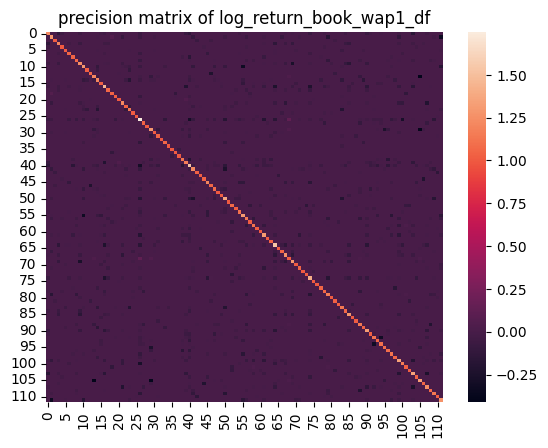








Start time index: 0, End time index: 90
time id start: 4294, time id end: 19090
Cluster 1: [13, 51, 93], Number of stocks: 3
Cluster 2: [19, 21, 39, 114], Number of stocks: 4
Cluster 3: [5, 11, 15, 23, 26], Number of stocks: 5
Cluster 3: [37, 95], Number of stocks: 2
Cluster 4: [28], Number of stocks: 1
Cluster 5: [1, 6, 8, 20, 29], Number of stocks: 5
Cluster 5: [36, 44, 50, 52, 56], Number of stocks: 5
Cluster 5: [60, 61, 66, 69, 80], Number of stocks: 5
Cluster 5: [81, 82, 89, 101, 113], Number of stocks: 5
Cluster 5: [124], Number of stocks: 1
Cluster 6: [31], Number of stocks: 1
Cluster 7: [35], Number of stocks: 1
Cluster 8: [38, 40], Number of stocks: 2
Cluster 9: [0, 7, 34, 41, 43], Number of stocks: 5
Cluster 9: [67, 70, 72, 87, 96], Number of stocks: 5
Cluster 9: [103, 105, 109, 111, 118], Number of stocks: 5
Cluster 10: [2, 46, 125], Number of stocks: 3
Cluster 11: [47, 74], Number of stocks: 2
Cluster 12: [4, 48, 120], Number of stocks: 3
Cluster 13: [58], Number of 

In [ ]:
"""
Save individual regimes independently to not lose them for further analysis

"""
for regime in range(len(split_idxs_into_regimes) ): # -20
    print(f"regime: {regime}")
    mvarch_regime_training(regime)





In [14]:
mvarch_uv_rvol_pred_df_st_dist_constant_u_log_return_book_wap1_df_2.dropna()

,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
1822,0.913192,1.634203,0.790357,0.86551,2.126447,1.108967,0.736396,0.934969,0.948343,0.727228,...,0.771681,0.564436,0.931246,1.113796,1.032113,0.776544,0.931151,2.739599,0.933062,1.108689
8426,0.712618,1.122737,0.785178,0.862405,1.473678,1.068344,0.633753,0.982376,0.883644,0.729571,...,0.85547,0.913123,0.736424,1.156429,1.060877,0.769455,0.57417,1.286164,0.987866,0.725666
13124,0.879341,0.906372,0.817401,2.410324,0.876547,0.867969,0.681487,0.968084,0.912436,0.824105,...,0.96766,0.732888,0.710985,0.737725,1.05715,0.771173,0.387464,1.34595,0.850597,0.703909
2075,0.889014,0.692888,0.941221,1.89847,0.751602,0.970651,0.55055,0.908453,0.428473,0.762628,...,1.228551,0.430531,0.900175,1.31271,1.117297,0.765835,0.660994,1.150397,0.955271,0.681875
7447,0.921186,0.735482,1.108014,0.890601,0.989821,0.753216,0.688063,1.42999,0.883079,0.982436,...,1.195783,0.862278,0.99542,1.892938,1.083008,0.793214,0.733501,1.13414,0.760449,0.736023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,1.248391,3.686152,1.39752,2.530674,2.645954,1.515411,3.601144,1.225303,2.23831,1.173389,...,1.815686,2.029601,2.210039,1.317141,2.475674,1.278427,1.891127,1.711675,0.969599,1.345009
8647,0.768668,2.839834,1.408855,1.325912,1.377235,1.44576,2.807017,0.977147,1.128218,1.096721,...,1.586418,1.553472,1.888743,0.935749,2.432381,0.925591,1.398832,0.920031,1.410213,1.524792
8618,1.197989,1.770216,1.378031,1.267445,1.318116,1.342507,2.845795,0.514891,1.072504,1.126953,...,0.718049,1.211909,1.337381,1.097926,1.053913,0.905137,1.304783,0.615813,0.725217,1.051732
17791,2.345611,1.509426,0.939199,1.181727,1.358207,1.380075,3.014666,0.629652,1.850905,1.077762,...,0.926111,1.098887,1.30264,1.145894,2.377379,0.798001,1.284756,0.741724,0.733187,0.987249


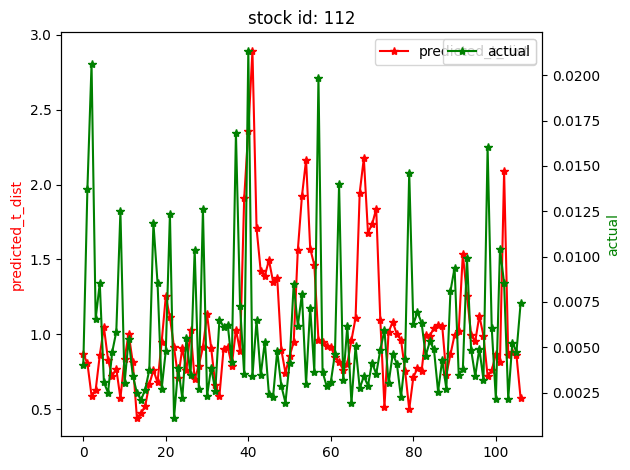

In [13]:
"""
Evaluate Mvarch predictions on book wap1 volatilities.

"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/mvarch_features/results/student_t_Regimes')
mvarch_uv_rvol_pred_df_st_dist_constant_u_log_return_book_wap1_df_2 = pickle.load( open('mvarch_uv_rvol_pred_df_st_dist_constant_u_log_return_book_wap1_df_2.pkl', 'rb'))
# all_mvarch_uv_model_std_predicted_df_mean_constant = pickle.load( open('mvarch_uv_model_std_predicted_df_st_dist_constant_u_log_return_book_wap1_df_0.pkl', 'rb'))

############## Book WAP1 volotitliy start ##############
########################################################



stock_id = 112
pred = mvarch_uv_rvol_pred_df_st_dist_constant_u_log_return_book_wap1_df_2.iloc[91:198][str(stock_id)]
# pred1 = all_mvarch_uv_model_std_predicted_df_mean_constant.iloc[91:198][str(stock_id)]
actual = first_10_min_wap1_vol_df.iloc[91:198][stock_id]


fig, ax1 = plt.subplots()
ax1.plot(range(len(pred)),pred, label='predicted_t_dist',marker='*',color='red')
ax1.set_ylabel('predicted_t_dist', color='red')
#ax1.plot(range(len(pred1)),pred1, label='std_t_dist',marker='*')
#ax1.plot(range(len(pred1)),pred/pred1, label='pred/std_t_dist',marker='*',color='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(range(len(actual)),actual, label='actual',marker='*',color='green')
ax2.set_title('stock id: '+str(stock_id))
ax2.legend()
ax2.set_ylabel('actual', color='green')

fig.tight_layout()
######### Evaluation metric #########
## CORRELATION Coefficient is appropriate but
## R^2 = 1 - SSR/SST is just square of correlation coefficient so we can use this!
## SST = Sum of Squared Total, SSR = Sum of squared Residuals




############## Book WAP1 volotitliy end ################
########################################################



In [ ]:
"""
Plot ACF and PACF for book wap1 volatilities.

"""

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true) ))

def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def spearman(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def r2(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]**2


all_rmse = []
all_mse = []
all_spearman = []
all_r2 = []

def compute_acf_pacf_n_metrics(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,start_idx,end_idx):
    ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
    plt.close('all')
    tot_lags = 52
    for s in unique_stock_ids[-10:]: #unique_stock_ids:
        y_true = all_stock_y_train_df.iloc[start_idx:end_idx][int(s)].values
        y_pred = all_stock_train_pred_df.iloc[start_idx:end_idx][str(s)].values
        y_pred[ np.where(y_pred == np.inf) ] = 5
        y_pred[ np.where(y_pred == -np.inf) ] = 0
        stock_residual = y_true - y_pred

        fig,ax = plt.subplots(2,1,figsize=(30,6))
        plot_acf(stock_residual, lags=tot_lags,ax=ax[0])
        plot_pacf(stock_residual, lags=tot_lags,ax=ax[1])
        ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
        ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
        ax[0].set_xticks(range(0,tot_lags,5))
        ax[1].set_xticks(range(0,tot_lags,5))
        ax[1].set_xlabel('lags')
        ax[0].set_ylabel('ACF')
        ax[1].set_ylabel('PACF')
        ax[0].grid(True)
        ax[1].grid(True)
        fig.show()

        rmse_s = rmse(y_true, y_pred)
        mse_s = mse(y_true, y_pred)
        spearman_s = spearman(y_true, y_pred)
        r2_s = r2(y_true, y_pred)
        all_rmse.append(rmse_s)
        all_mse.append(mse_s)
        all_spearman.append(spearman_s)
        all_r2.append(r2_s)
        print('stock id: ',s)
        print('rmse: ',rmse_s)
        print('mse: ',mse_s)
        print('spearman: ',spearman_s)
        print('r2: ',r2_s)

    print('mean rmse for all stocks: ',np.mean(all_rmse))
    print('mean mse for all stocks: ',np.mean(all_mse))
    print('mean spearman for all stocks: ',np.mean(all_spearman))
    print('mean r2 for all stocks: ',np.mean(all_r2))

    return np.mean(all_rmse) , np.mean(all_mse) , np.mean(all_spearman) , np.mean(all_r2)


start_idx,end_idx = 91,198
##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
mean_rmse, mean_mse, mean_spearman, mean_r2  = compute_acf_pacf_n_metrics(unique_stock_ids,all_mvarch_uv_rvol_predicted_df_mean_constant,first_10_min_wap1_vol_df,start_idx,end_idx)
print('mean rmse for all stocks: ',mean_rmse)
print('mean mse for all stocks: ',mean_mse)
print('mean spearman for all stocks: ',mean_spearman)
print('mean r2 for all stocks: ',mean_r2)

In [ ]:
"""
Plot ACF and PACF for book wap1 volatilities.

"""

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true) ))

def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def spearman(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def r2(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]**2



unique_stock_ids = HAR_book_wap1_final_predictions['st_id'].unique()

def compute_acf_pacf_n_metrics(unique_stock_ids,HAR_book_wap1_final_predictions,HAR_types):

    all_rmse = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_mse = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_spearman = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_r2 = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}

    plt.close('all')
    tot_lags = 100
    for s in unique_stock_ids:#[0:1]: #unique_stock_ids:
        data = HAR_book_wap1_final_predictions
        data = data[data['st_id']==s]

        y_true = data.iloc[54:]['outRV'].values
        #fig,ax = plt.subplots(2,1,figsize=(30,10))
        for har_type in HAR_types:
            y_pred = data.iloc[54:][har_type].values
            # y_pred[ np.where(y_pred == np.inf) ] = 5
            # y_pred[ np.where(y_pred == -np.inf) ] = 0
            stock_residual = y_true - y_pred

            ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
            # plot_acf(stock_residual, lags=tot_lags,ax=ax[0],label=har_type,alpha=0.5)
            # plot_pacf(stock_residual, lags=tot_lags,ax=ax[1],label=har_type,alpha=0.5)
            # ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            # ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            # ax[0].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xlabel('lags')
            # ax[0].set_ylabel('ACF')
            # ax[1].set_ylabel('PACF')
            # ax[0].legend(loc='upper left')
            # ax[1].legend(loc='upper left')
            # ax[0].set_ylim([-0.2,0.2])
            # ax[1].set_ylim([-0.2,0.2])
            # ax[0].grid(True)
            # ax[1].grid(True)
            # fig.tight_layout()
            # fig.show()

            rmse_s = rmse(y_true, y_pred)
            mse_s = mse(y_true, y_pred)
            spearman_s = spearman(y_true, y_pred)
            r2_s = r2(y_true, y_pred)
            all_rmse[har_type].append(rmse_s)
            all_mse[har_type].append(mse_s)
            all_spearman[har_type].append(spearman_s)
            all_r2[har_type].append(r2_s)
            # print('stock id: ',s)
            # print('HAR type: ',har_type)
            # print('rmse: ',rmse_s)
            # print('mse: ',mse_s)
            # print('spearman: ',spearman_s)
            # print('r2: ',r2_s)

    model_names = ['AR', 'HAR', 'HARQ', 'HARQF', 'CHAR', 'SHAR', 'HARJ']
    HAR_error_metrics = pd.DataFrame(index= model_names, columns= ["rmse", "mse", ])
    HAR_corr_metrics = pd.DataFrame(index= model_names, columns= [ "spearman","r2"])
    for har_type,m_name in zip(HAR_types,model_names):
        #print('\n\n\nGLOBAL Mean Metric for HAR type: ',har_type)
        sum_rmse = np.sum(all_rmse[har_type])
        sum_mse = np.sum(all_mse[har_type])
        sum_spearman = np.sum(all_spearman[har_type])
        sum_r2 = np.sum(all_r2[har_type])
        HAR_error_metrics.loc[m_name] = [sum_rmse, sum_mse, ]
        HAR_corr_metrics.loc[m_name] = [sum_spearman, sum_r2]

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_error_metrics.plot.bar(ax=ax)
    ax.set_title('book_wap1, differnt HAR_type models:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks HAR_error_metrics')
    ax.set_ylim([0,0.04])
    ax.set_yticks(np.arange(0,0.04,0.01))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics['spearman'].plot.bar(ax=ax,color=['red'])
    ax.set_title('book_wap1, differnt HAR_type models:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks spearman')
    ax.set_ylim([43,47])
    ax.set_yticks(np.arange(43,47,0.2))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics["r2"].plot.bar(ax=ax,color=['green'])
    ax.set_title('book_wap1, differnt HAR_type models:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks r2')
    ax.set_ylim([7,9])
    ax.set_yticks(np.arange(7,9,0.2))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    return

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features/final_features_for_xgboost')
HAR_book_wap1_all_predictions = pd.read_parquet('HAR_book_wap1_all_predictions.parquet')

HAR_types = ['all_predsA',	'all_preds',	'all_predsQ',	'all_predsF',	'all_predsC',	'all_predsS',	'all_predsJ']
#HAR_types = ['all_predsQ']
##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
compute_acf_pacf_n_metrics(unique_stock_ids,HAR_book_wap1_all_predictions,HAR_types)



array([2., 5., 5.])

In [ ]:
"""
Check which model has least error for trade price volatilities
"""





unique_stock_ids = HAR_trade_price_final_predictions_errors_dict.keys()

all_st_AR_mse_sum = []
all_st_AR_mae_sum = []
all_st_HAR_mse_sum = []
all_st_HAR_mae_sum = []
all_st_HARQ_mse_sum = []
all_st_HARQ_mae_sum = []
all_st_HARQF_mse_sum = []
all_st_HARQF_mae_sum = []
all_st_CHAR_mse_sum = []
all_st_CHAR_mae_sum = []
all_st_SHAR_mse_sum = []
all_st_SHAR_mae_sum = []
all_st_HARJ_mse_sum = []
all_st_HARJ_mae_sum = []


for s in unique_stock_ids:
    #print('stock id: ',s)
    all_st_AR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['AR_mse'] )
    all_st_AR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['AR_mae'] )
    all_st_HAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HAR_mse'] )
    all_st_HAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HAR_mae'] )
    all_st_HARQ_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQ_mse'] )
    all_st_HARQ_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQ_mae'] )
    all_st_HARQF_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQF_mse'] )
    all_st_HARQF_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQF_mae'] )
    all_st_CHAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['CHAR_mse'] )
    all_st_CHAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['CHAR_mae'] )
    all_st_SHAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['SHAR_mse'] )
    all_st_SHAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['SHAR_mae'] )
    all_st_HARJ_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARJ_mse'] )
    all_st_HARJ_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARJ_mae'] )

all_st_AR_mse_sum = np.sum(all_st_AR_mse_sum)
all_st_AR_mae_sum = np.sum(all_st_AR_mae_sum)
all_st_HAR_mse_sum = np.sum(all_st_HAR_mse_sum)
all_st_HAR_mae_sum = np.sum(all_st_HAR_mae_sum)
all_st_HARQ_mse_sum = np.sum(all_st_HARQ_mse_sum)
all_st_HARQ_mae_sum = np.sum(all_st_HARQ_mae_sum)
all_st_HARQF_mse_sum = np.sum(all_st_HARQF_mse_sum)
all_st_HARQF_mae_sum = np.sum(all_st_HARQF_mae_sum)
all_st_CHAR_mse_sum = np.sum(all_st_CHAR_mse_sum)
all_st_CHAR_mae_sum = np.sum(all_st_CHAR_mae_sum)
all_st_SHAR_mse_sum = np.sum(all_st_SHAR_mse_sum)
all_st_SHAR_mae_sum = np.sum(all_st_SHAR_mae_sum)
all_st_HARJ_mse_sum = np.sum(all_st_HARJ_mse_sum)
all_st_HARJ_mae_sum = np.sum(all_st_HARJ_mae_sum)


fig, ax = plt.subplots(figsize=(15,5))
x = ['HAR_mse', 'HAR_mae', 'HARJ_mse','HARJ_mae', 'AR_mse','AR_mae', 'CHAR_mse','CHAR_mae', 'SHAR_mse','SHAR_mae','HARQF_mse','HARQF_mae', 'HARQ_mse','HARQ_mae']
y = [all_st_HAR_mse_sum, all_st_HAR_mae_sum, all_st_HARJ_mse_sum, all_st_HARJ_mae_sum, all_st_AR_mse_sum, all_st_AR_mae_sum, all_st_CHAR_mse_sum,\
     all_st_CHAR_mae_sum, all_st_SHAR_mse_sum, all_st_SHAR_mae_sum,all_st_HARQF_mse_sum, all_st_HARQF_mae_sum, all_st_HARQ_mse_sum, all_st_HARQ_mae_sum]
colors = ['skyblue', 'lightgreen'] * 7  # Alternating colors for each pair
ax.bar(x,y, color=colors)
ax.set_title('HAR_trade_price_final_predictions_errors_dict')
ax.set_xlabel('Metric')
ax.set_ylabel('Sum of 112 stocks Errors')
ax.set_ylim([0,0.04])
ax.set_yticks(np.arange(0,0.04,0.005))
ax.grid(True)
fig.tight_layout()
fig.show()

In [ ]:
"""
Evaluate Mvarch predictions on trade price volatilities.

"""











############## trade price volotitliy start ##############
##########################################################
#first_10_min_trade_price_vol_df





######### Evaluation metric #########
## R^2




############## trade price volotitliy start ##############
##########################################################

1551     0.003427
22899    0.001338
20973    0.006915
25234    0.005776
5910     0.001878
30177    0.003710
30940    0.001804
18200    0.004778
6483     0.002329
21139    0.006301
7316     0.005496
22013    0.001135
27851    0.005359
18072    0.011131
Name: 0, dtype: float64